In [1]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from tqdm import tqdm

from PIL import Image
from torch.utils.data import DataLoader

from deeplab3.config.defaults import get_cfg_defaults
from deeplab3.dataloaders.utils import sample_distribution
from deeplab3.dataloaders.utils import decode_segmap

from deeplab3.dataloaders.datasets.cityscapes import CityscapesSegmentation
from deeplab3.dataloaders.datasets.coco import COCOSegmentation
from deeplab3.dataloaders.datasets.sunrgbd import RGBDSegmentation
from deeplab3.dataloaders.datasets.scenenet import SceneNetSegmentation


from deeplab3.dataloaders.SampleLoader import SampleLoader

In [2]:
def plot_distribution(a_list, bins, percent=False):
    ax = plt.figure()
    bin_middle = np.array([(bins[x] + bins[x + 1]) / 2.0 for x in range(len(bins) - 1)])
    for a in a_list:
        n = np.histogram(a, bins=bins)[0]
        if percent:
            n = n / np.sum(n)
        # y = scipy.stats.norm.pdf(b, 0, 1)
        plt.plot(bin_middle[np.nonzero(n)], n[np.nonzero(n)])

    return ax

In [3]:
def visualize_sample(loader, sample, dataset):
    img_tmp = loader.invert_normalization(sample['image'].squeeze())
    gt = sample['label'].numpy()
    tmp = np.array(gt[0]).astype(np.uint8)
    segmap = decode_segmap(tmp, dataset=dataset)
    
    print(sample['id'])
    plt.figure(figsize=(16, 8))
    
    plt.subplot('141')
    plt.imshow(img_tmp[:,:,:3])
    plt.title('image')
    plt.axis('off')
    
    plt.subplot('142')
    plt.imshow(img_tmp[:,:,3:].squeeze())
    plt.title('depth')
    plt.axis('off')
    
    plt.subplot('143')
    plt.imshow(segmap)
    plt.title('labels')
    plt.axis('off')

Load configuation files for all datasets

In [4]:
sunrgbd_rgbd = get_cfg_defaults()
sunrgbd_rgbd.merge_from_file('../configs/sunrgbd.yaml')
sunrgbd_rgbd.merge_from_list(['DATASET.ROOT', '../datasets/SUNRGBD/'])

coco_synth = get_cfg_defaults()
coco_synth.merge_from_file('../configs/coco_rgbd.yaml')
coco_synth.merge_from_list(['DATASET.ROOT', '../datasets/coco/'])

# Coarse labels not available for test set
city_rgbd = get_cfg_defaults()
city_rgbd.merge_from_file('../configs/cityscapes_rgbd.yaml')
city_rgbd.merge_from_list(['DATASET.ROOT', '../datasets/cityscapes/']) #, 'DATASET.CITYSCAPES.GT_MODE', 'gtFine'])

city_synth = get_cfg_defaults()
city_synth.merge_from_file('../configs/cityscapes_synthetic_rgbd.yaml')
city_synth.merge_from_list(['DATASET.ROOT', '../datasets/cityscapes/', 'DATASET.CITYSCAPES.GT_MODE', 'gtFine'])

city_hha = get_cfg_defaults()
city_hha.merge_from_file('../configs/HHA/cityscapes_hha_midfusion.yaml')
city_hha.merge_from_list(['DATASET.ROOT', '../datasets/cityscapes/', 'DATASET.CITYSCAPES.GT_MODE', 'gtFine'])

scenenet = get_cfg_defaults()
scenenet.merge_from_file('../configs/scenenet_rgbd.yaml')
scenenet.merge_from_list(['DATASET.ROOT', '../datasets/scenenet/'])

## Measured (real) Depth Histograms

In [5]:
city_rgbd_dist_train = sample_distribution(CityscapesSegmentation(city_rgbd, split='train_extra'), n=100)
city_rgbd_dist_val = sample_distribution(CityscapesSegmentation(city_rgbd, split='val'), n=100)
city_rgbd_dist_test = sample_distribution(CityscapesSegmentation(city_rgbd, split='train'), n=100)

Using RGB-D input


0it [00:00, ?it/s]

Found 19997 train_extra images


100it [00:39,  2.51it/s]
0it [00:00, ?it/s]

Using RGB-D input
Found 500 val images


100it [00:33,  3.01it/s]
0it [00:00, ?it/s]

Using RGB-D input
Found 2975 train images


100it [00:38,  2.59it/s]


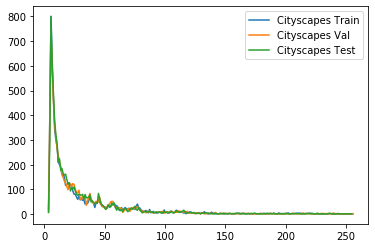

In [6]:
city_depth_samples = city_rgbd_dist_train['samples'][:, -1]
city_depth_samples_train = city_depth_samples[np.nonzero(city_depth_samples)]
city_depth_samples = city_rgbd_dist_val['samples'][:, -1]
city_depth_samples_val = city_depth_samples[np.nonzero(city_depth_samples)]
city_depth_samples = city_rgbd_dist_test['samples'][:, -1]
city_depth_samples_test = city_depth_samples[np.nonzero(city_depth_samples)]

bins = np.linspace(-1,256, num=256)
plot_distribution([city_depth_samples_train, 
                   city_depth_samples_val,
                   city_depth_samples_test], bins)
plt.legend(['Cityscapes Train', 'Cityscapes Val', 'Cityscapes Test'])
plt.show()

In [7]:
print("Cityscapes mean: {} \n \t std: {}".format(city_rgbd_dist_train['mean'], 
                                                 city_rgbd_dist_train['std']))

Cityscapes mean: [79.193      89.7923     78.8073     26.68875827] 
 	 std: [48.422581   49.45575761 49.12799982 46.38161247]


Using RGB-D input
Found 2975 train images
['../datasets/cityscapes/leftImg8bit/train/monchengladbach/monchengladbach_000000_006169_leftImg8bit.png']


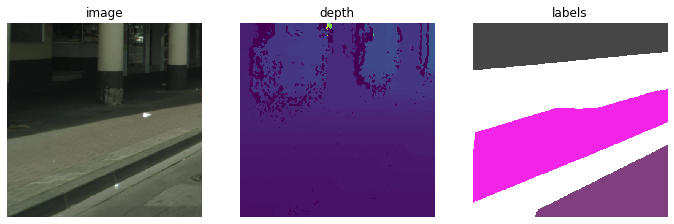

In [5]:
city_val = CityscapesSegmentation(city_rgbd, split='train')
dataloader = DataLoader(city_val, batch_size=1, shuffle=True, num_workers=0)
for ii, sample in enumerate(dataloader):
    visualize_sample(city_val.loader, sample, 'cityscapes')
    break

['../datasets/cityscapes/leftImg8bit/train/strasbourg/strasbourg_000000_016311_leftImg8bit.png']


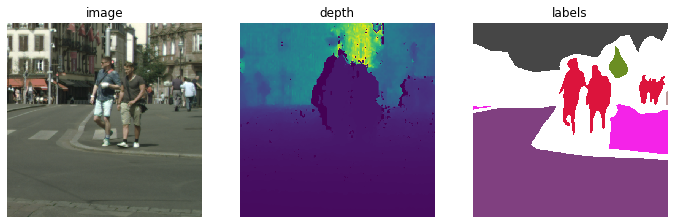

In [9]:
for ii, sample in enumerate(dataloader):
    visualize_sample(city_val.loader, sample, 'cityscapes')
    break

In [10]:
sunrgbd_rgbd_dist_train = sample_distribution(RGBDSegmentation(sunrgbd_rgbd, split='train'), n=100)
sunrgbd_rgbd_dist_val = sample_distribution(RGBDSegmentation(sunrgbd_rgbd, split='val'), n=100)
sunrgbd_rgbd_dist_test = sample_distribution(RGBDSegmentation(sunrgbd_rgbd, split='test'), n=100)

loading annotations into memory...


2it [00:00, 15.71it/s]

Done (t=0.23s)
creating index...
index created!
Using RGB-D input


100it [00:06, 14.76it/s]
0it [00:00, ?it/s]

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
Using RGB-D input


100it [00:07, 13.59it/s]


loading annotations into memory...


2it [00:00, 10.61it/s]

Done (t=0.35s)
creating index...
index created!
Using RGB-D input


100it [00:07, 13.90it/s]


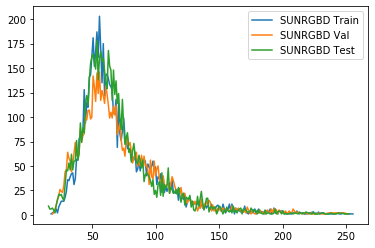

In [11]:
sun_depth_samples = sunrgbd_rgbd_dist_train['samples'][:, -1]
sun_depth_samples_train = sun_depth_samples[np.nonzero(sun_depth_samples)]

sun_depth_samples = sunrgbd_rgbd_dist_val['samples'][:, -1]
sun_depth_samples_val = sun_depth_samples[np.nonzero(sun_depth_samples)]

sun_depth_samples = sunrgbd_rgbd_dist_test['samples'][:, -1]
sun_depth_samples_test = sun_depth_samples[np.nonzero(sun_depth_samples)]

bins = np.linspace(0,256, num=256)
plot_distribution([sun_depth_samples_train, 
                   sun_depth_samples_val,
                   sun_depth_samples_test], bins)
plt.legend(['SUNRGBD Train', 'SUNRGBD Val', 'SUNRGBD Test'])
plt.show()

In [12]:
print("SUNRGBD mean: {} \n \t std: {}".format(sunrgbd_rgbd_dist_train['mean'], 
                                                 sunrgbd_rgbd_dist_train['std']))

SUNRGBD mean: [133.1017 128.1998 122.3182  55.335 ] 
 	 std: [67.7155651  70.91682508 70.11145234 42.32245237]


loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
Using RGB-D input
tensor([5928])


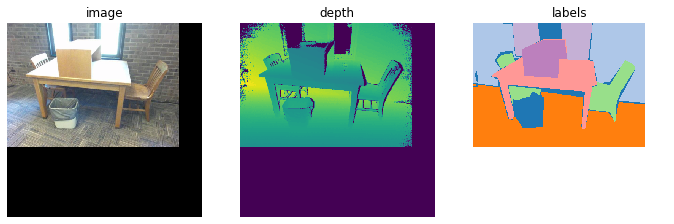

In [13]:
sunrgbd_val = RGBDSegmentation(sunrgbd_rgbd, split='train')
dataloader = DataLoader(sunrgbd_val, batch_size=1, shuffle=True, num_workers=0)
for ii, sample in enumerate(dataloader):
    visualize_sample(sunrgbd_val.loader, sample, 'sunrgbd')
    break

tensor([5243])


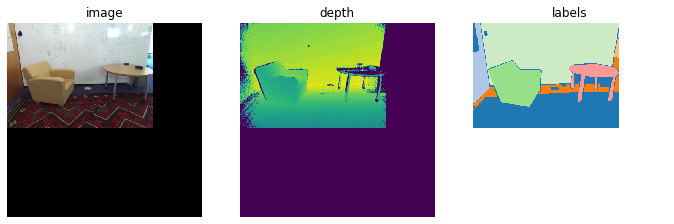

In [14]:
for ii, sample in enumerate(dataloader):
    visualize_sample(sunrgbd_val.loader, sample, 'sunrgbd')
    break

## Cityscapes HHA vs RGB

Comparison between the histogram of the RGB values and the HHA values shows a very different data characteristics that hinder transfer learning

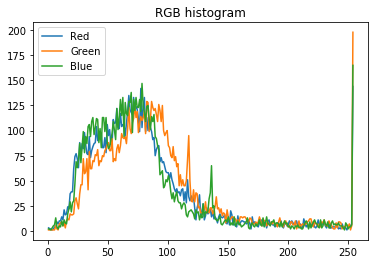

In [15]:
bins = np.linspace(0,255, num=256)
plot_distribution([city_rgbd_dist_train['samples'][:, 0],
                  city_rgbd_dist_train['samples'][:, 1],
                  city_rgbd_dist_train['samples'][:, 2]], bins)
plt.title("RGB histogram")
plt.legend(["Red", "Green", "Blue"])
plt.show()


In [16]:
city_hha_dist_train = sample_distribution(CityscapesSegmentation(city_hha, split='train'), n=100)
city_hha_dist_val = sample_distribution(CityscapesSegmentation(city_hha, split='val'), n=100)
city_hha_dist_test = sample_distribution(CityscapesSegmentation(city_hha, split='test'), n=100)

0it [00:00, ?it/s]

Using RGB HHA input
Found 2975 train images


100it [00:41,  2.41it/s]
0it [00:00, ?it/s]

Using RGB HHA input
Found 500 val images


100it [00:34,  2.92it/s]
0it [00:00, ?it/s]

Using RGB HHA input
Found 1525 test images


100it [00:37,  2.65it/s]


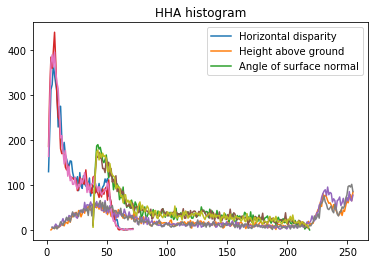

In [17]:
bins = np.linspace(0,255, num=256)

#Train
H1 = city_hha_dist_train['samples'][:,3]
H1_train = H1[np.nonzero(H1)]

H2 = city_hha_dist_train['samples'][:,4]
H2 = H2[np.nonzero(H2)]
H2_train = H2[H2<255]

A = city_hha_dist_train['samples'][:,5]
A_train = A[np.nonzero(A)]

# Val
H1 = city_hha_dist_val['samples'][:,3]
H1_val = H1[np.nonzero(H1)]

H2 = city_hha_dist_val['samples'][:,4]
H2 = H2[np.nonzero(H2)]
H2_val = H2[H2<255]

A = city_hha_dist_val['samples'][:,5]
A_val = A[np.nonzero(A)]

#Test
H1 = city_hha_dist_test['samples'][:,3]
H1_test = H1[np.nonzero(H1)]

H2 = city_hha_dist_test['samples'][:,4]
H2 = H2[np.nonzero(H2)]
H2_test = H2[H2<255]

A = city_hha_dist_test['samples'][:,5]
A_test = A[np.nonzero(A)]


plot_distribution([H1_train, H2_train, A_train,
                  H1_val, H2_val, A_val,
                  H1_test, H2_test, A_test], bins)
plt.title("HHA histogram")
plt.legend(["Horizontal disparity", "Height above ground", "Angle of surface normal"])
plt.show()


In [18]:
print("Cityscapes HHA mean: {} \n \t std: {}".format(city_hha_dist_train['mean'], 
                                                 city_hha_dist_train['std']))

Cityscapes HHA mean: [ 73.338   82.9697  72.6968  17.1777 128.4546  77.5813] 
 	 std: [ 47.86850484  48.33375613  47.69767992  16.59610565 102.62858052
  59.05769036]


Using RGB HHA input
Found 2975 train images
['../datasets/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000116_000019_leftImg8bit.png']


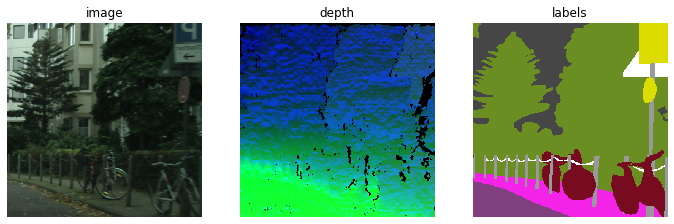

In [19]:
city_hha_val = CityscapesSegmentation(city_hha, split='train')
dataloader = DataLoader(city_hha_val, batch_size=1, shuffle=True, num_workers=0)
for ii, sample in enumerate(dataloader):
    visualize_sample(city_hha_val.loader, sample, 'cityscapes')
    break

## COCO VNL Monocular Depth Estimation
COCO synthetic depth is generated using a model trained on NYUv2, a dataset of interior scenes. Therefore the estimated depths range between \[0, 12\] meters

In [20]:
coco_synth_dist_train = sample_distribution(COCOSegmentation(coco_synth, split='train'), n=100)
coco_synth_dist_val = sample_distribution(COCOSegmentation(coco_synth, split='val'), n=100)
#coco_synth_dist_test = sample_distribution(COCOSegmentation(coco_synth, split='test'), n=100)

loading annotations into memory...
Done (t=20.40s)
creating index...


0it [00:00, ?it/s]

index created!
Using RGB-D input


100it [00:15,  6.51it/s]


loading annotations into memory...


1it [00:00,  7.10it/s]

Done (t=0.78s)
creating index...
index created!
Using RGB-D input


100it [00:12,  7.92it/s]


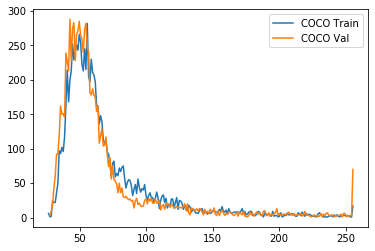

In [21]:
bins = np.linspace(0,256, num=256)
plot_distribution([coco_synth_dist_train['samples'][:, -1], 
                   coco_synth_dist_val['samples'][:, -1]], bins)
                   #coco_synth_dist_test['samples'][:, -1]], bins)
plt.legend(['COCO Train', 'COCO Val'])
plt.show()

In [22]:
print("COCO VNL mean: {} \n \t std: {}".format(coco_synth_dist_train['mean'], 
                                                 coco_synth_dist_train['std']))

COCO VNL mean: [119.0222 116.8671 107.5183  70.4671] 
 	 std: [72.18208716 70.56836145 75.16428983 36.50209196]


loading annotations into memory...
Done (t=19.29s)
creating index...
index created!
Using RGB-D input
tensor([60983])


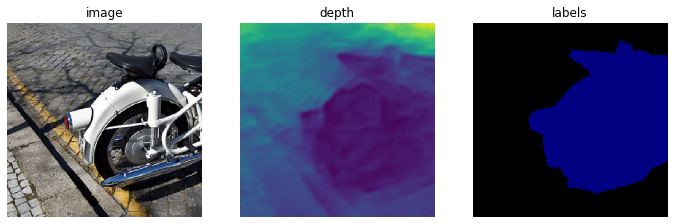

In [6]:
coco_val = COCOSegmentation(coco_synth, split='train')
dataloader = DataLoader(coco_val, batch_size=1, shuffle=True, num_workers=0)
for ii, sample in enumerate(dataloader):
    visualize_sample(coco_val.loader, sample, 'coco')
    break

## Cityscapes VNL Monocular Depth Estimation
Cityscapes synthetic depth is generated using a model trained on KITTI, a dataset for autonomous driving. Therefore the estimated depths range between \[0, 150\] meters

In [25]:
city_synth_dist_train = sample_distribution(CityscapesSegmentation(city_synth, split='train'), n=100)
city_synth_dist_val = sample_distribution(CityscapesSegmentation(city_synth, split='val'), n=100)
city_synth_dist_test = sample_distribution(CityscapesSegmentation(city_synth, split='test'), n=100)

Using RGB-D input


0it [00:00, ?it/s]

Found 2975 train images


100it [00:51,  1.95it/s]
0it [00:00, ?it/s]

Using RGB-D input
Found 500 val images


100it [00:34,  2.93it/s]
0it [00:00, ?it/s]

Using RGB-D input
Found 1525 test images


100it [00:34,  2.87it/s]


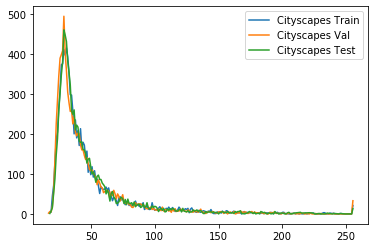

In [26]:
bins = np.linspace(0,256, num=256)
plot_distribution([city_synth_dist_train['samples'][:, -1], 
                   city_synth_dist_val['samples'][:, -1],
                   city_synth_dist_test['samples'][:, -1]], bins)
plt.legend(['Cityscapes Train', 'Cityscapes Val', 'Cityscapes Test'])
plt.show()

In [27]:
print("Cityscapes VNL mean: {} \n \t std: {}".format(city_synth_dist_train['mean'], 
                                                 city_synth_dist_train['std']))

Cityscapes VNL mean: [72.8345 83.0208 73.1291 49.5725] 
 	 std: [48.67997237 49.64834909 49.03904397 34.64030519]


Using RGB-D input
Found 2975 train images
['../datasets/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000146_000019_leftImg8bit.png']


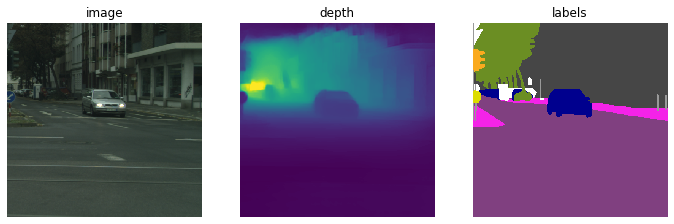

In [28]:
city_synth_val = CityscapesSegmentation(city_synth, split='train')
dataloader = DataLoader(city_synth_val, batch_size=1, shuffle=True, num_workers=0)
for ii, sample in enumerate(dataloader):
    visualize_sample(city_synth_val.loader, sample, 'cityscapes')
    break

## Scenenet Synthetic Rendered Depth

In [9]:
# scenenet_dist_train = sample_distribution(SceneNetSegmentation(scenenet, split='train'), n=100)
# scenenet_dist_val = sample_distribution(SceneNetSegmentation(scenenet, split='val'), n=100)
scenenet_dist_test = sample_distribution(SceneNetSegmentation(scenenet, split='test'), n=100)

1it [00:00,  4.98it/s]

Using RGB-D input
Found 293214 test images


100it [00:07, 12.59it/s]


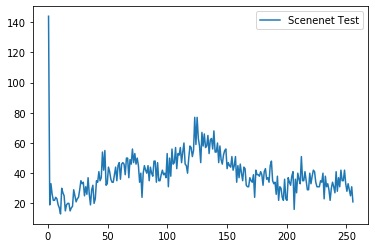

In [12]:
bins = np.linspace(0,256, num=256)
plot_distribution([scenenet_dist_test['samples'][:, -1]], bins)
plt.legend(['Scenenet Test'])
plt.show()

In [14]:
print("Scenenet mean: {} \n \t std: {}".format(scenenet_dist_test['mean'], 
                                                 scenenet_dist_test['std']))

Scenenet mean: [107.8117 100.2923  95.7429 128.0009] 
 	 std: [63.07900794 64.04474265 63.45956508 67.40844531]


Using RGB-D input
Found 293214 test images
['../datasets/scenenet/train/0/9/photo/2050.jpg']


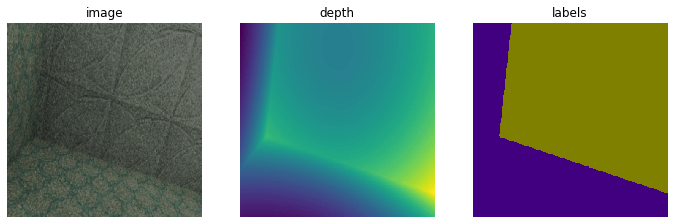

In [5]:
scenenet_test = SceneNetSegmentation(scenenet, split='test')
dataloader = DataLoader(scenenet_test, batch_size=1, shuffle=True, num_workers=0)
for ii, sample in enumerate(dataloader):
    visualize_sample(scenenet_test.loader, sample, 'coco')
    break

## Comparison of estimated and target distributions
We use the synthetic depth to pretrain segmentation networks for smaller datasets with real depth. The COCO dataset is used to pretrain for segmenting the SUNRGBD dataset. And the Cityscapes dataset is used to experiment with synthetic pretraining on different dataset scales. 

In the following plot, we compare the distributions to show the differences between the pretraining and real depth measurements.

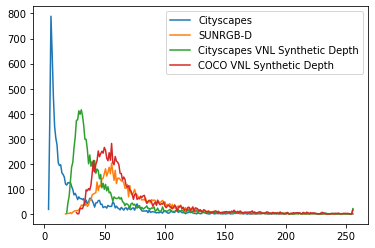

In [29]:
city_depth_samples = city_rgbd_dist_train['samples'][:, -1]
city_depth_samples = city_depth_samples[np.nonzero(city_depth_samples)]

city_synth_samples = city_synth_dist_train['samples'][:, -1]
city_synth_samples = city_synth_samples[np.nonzero(city_synth_samples)]

coco_depth_samples = coco_synth_dist_train['samples'][:, -1]
coco_depth_samples = coco_depth_samples[np.nonzero(coco_depth_samples)]

sun_depth_samples = sunrgbd_rgbd_dist_train['samples'][:, -1]
sun_depth_samples = sun_depth_samples[np.nonzero(sun_depth_samples)]
sun_depth_samples = sun_depth_samples[sun_depth_samples<255]

bins = np.linspace(0,256, num=256)
plot_distribution([city_depth_samples, sun_depth_samples, 
                   city_synth_samples, coco_depth_samples], bins)
plt.legend(['Cityscapes', 'SUNRGB-D', 'Cityscapes VNL Synthetic Depth', 'COCO VNL Synthetic Depth'])
plt.show()

We normalize the datasets to zero mean and unit std.

In [30]:
def norm(samples, mean, std):
    return (samples - mean)/std

In [31]:
print("Cityscapes mean: {} \n \t std: {}".format(city_rgbd_dist_train['mean'], 
                                                 city_rgbd_dist_train['std']))
print("SUNRGBD mean: {} \n \t std: {}".format(sunrgbd_rgbd_dist_train['mean'], 
                                                 sunrgbd_rgbd_dist_train['std']))
print("Cityscapes VNL mean: {} \n \t std: {}".format(city_synth_dist_train['mean'], 
                                                 city_synth_dist_train['std']))
print("COCO VNL mean: {} \n \t std: {}".format(coco_synth_dist_train['mean'], 
                                                 coco_synth_dist_train['std']))

Cityscapes mean: [79.193      89.7923     78.8073     26.68875827] 
 	 std: [48.422581   49.45575761 49.12799982 46.38161247]
SUNRGBD mean: [133.1017 128.1998 122.3182  55.335 ] 
 	 std: [67.7155651  70.91682508 70.11145234 42.32245237]
Cityscapes VNL mean: [72.8345 83.0208 73.1291 49.5725] 
 	 std: [48.67997237 49.64834909 49.03904397 34.64030519]
COCO VNL mean: [119.0222 116.8671 107.5183  70.4671] 
 	 std: [72.18208716 70.56836145 75.16428983 36.50209196]


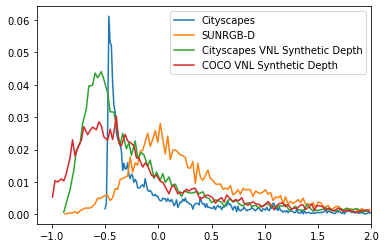

In [32]:
city_depth_samples = city_rgbd_dist_train['samples'][:, -1]
city_depth_samples = norm(city_depth_samples[np.nonzero(city_depth_samples)], 
                          city_rgbd_dist_train['mean'][-1], city_rgbd_dist_train['std'][-1])

city_synth_samples = city_synth_dist_train['samples'][:, -1]
city_synth_samples = norm(city_synth_samples[np.nonzero(city_synth_samples)], 
                          city_synth_dist_train['mean'][-1], city_synth_dist_train['std'][-1])

coco_depth_samples = coco_synth_dist_train['samples'][:, -1]
coco_depth_samples = norm(coco_depth_samples[np.nonzero(coco_depth_samples)], 
                          coco_synth_dist_train['mean'][-1], coco_synth_dist_train['std'][-1])

sun_depth_samples = sunrgbd_rgbd_dist_train['samples'][:, -1]
sun_depth_samples = sun_depth_samples[np.nonzero(sun_depth_samples)]
sun_depth_samples = norm(sun_depth_samples[sun_depth_samples<255], 
                         sunrgbd_rgbd_dist_train['mean'][-1], sunrgbd_rgbd_dist_train['std'][-1])

bins = np.linspace(-1,2, num=256)
plot_distribution([city_depth_samples, sun_depth_samples, 
                   city_synth_samples, coco_depth_samples], bins, percent=True)
plt.legend(['Cityscapes', 'SUNRGB-D', 'Cityscapes VNL Synthetic Depth', 'COCO VNL Synthetic Depth'])
plt.xlim(right=2)
plt.show()

## Experiments with Box Cox

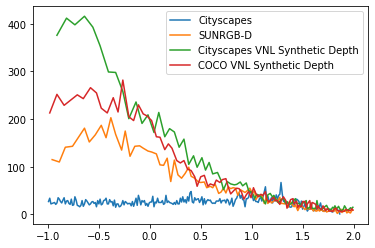

In [33]:
import scipy.stats

city_depth_samples = city_rgbd_dist_train['samples'][:, -1]
city_depth_samples_cox = scipy.stats.boxcox(city_depth_samples[np.nonzero(city_depth_samples)], -0.5)
city_depth_samples_cox = norm(city_depth_samples_cox, np.mean(city_depth_samples_cox), np.std(city_depth_samples_cox))


city_synth_samples = city_synth_dist_train['samples'][:, -1]
city_synth_samples_cox = scipy.stats.boxcox(city_synth_samples[np.nonzero(city_synth_samples)], -0.5)
city_synth_samples_cox = norm(city_synth_samples_cox, np.mean(city_synth_samples_cox), np.std(city_synth_samples_cox))


coco_depth_samples = coco_synth_dist_train['samples'][:, -1]
coco_depth_samples_cox = scipy.stats.boxcox(coco_depth_samples[np.nonzero(coco_depth_samples)], -0.5)
coco_depth_samples_cox = norm(coco_depth_samples_cox, np.mean(coco_depth_samples_cox), np.std(coco_depth_samples_cox))


sun_depth_samples = sunrgbd_rgbd_dist_train['samples'][:, -1]
sun_depth_samples_cox = scipy.stats.boxcox(sun_depth_samples[np.nonzero(sun_depth_samples)], -0.5)
sun_depth_samples_cox = norm(sun_depth_samples_cox, np.mean(sun_depth_samples_cox), np.std(sun_depth_samples_cox))


bins = np.linspace(-1,2, num=256)
plot_distribution([city_depth_samples_cox, sun_depth_samples_cox, 
                   city_synth_samples_cox, coco_depth_samples_cox], bins)
plt.legend(['Cityscapes', 'SUNRGB-D', 'Cityscapes VNL Synthetic Depth', 'COCO VNL Synthetic Depth'])
plt.show()